In [78]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, confusion_matrix, roc_auc_score, roc_curve, precision_score
from sklearn.ensemble import GradientBoostingClassifier

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

sns.set()

In [79]:
from loader import *
from neural_network import *
from plot import *
from train import *
from loss import *

# LOAD FILES AND PREPARE TRAIN AND TEST SET

In [80]:
insee_dataset = pd.read_csv('../data/data_INSEE_clean.csv', sep=';', dtype = {'code': str})
secound_round_result = pd.read_csv("../data/clean_s_round_elect_results.csv", sep = ",") 
secound_round_result = secound_round_result.drop(columns=["Inscrits", "% Abs/Ins"])


In [81]:

dataset = insee_dataset.merge(secound_round_result, how='inner', left_on='code', right_on='Code Insee') \
                             .drop(columns=["Code Insee"])


In [82]:
# DIFFERENT SETS OF FEATURES 
sparse_features = ['density_pop', 'Indice_vieillissement', 'ratio_etude_sup','mean_familiy_size',\
                   'ratio_no_diploma', 'hlm', 'res_second', 'ta_homme', 'part_agri_y', 'part_cadre']

all_features = list(set(insee_dataset.columns) - set(["code", "commune", "pop", "type_agglo"]))

features_wo_equipmements = list(set(all_features)-set(['hypermarché', 'pôle emploi','banques', 'poste', 'epicerie', \
                'boulangerie', 'boucherie', 'maternelle', 'élémentaire', 'collège', 'urgences', \
                'lycee', 'dentiste', 'medecin','infirmier', 'creche', 'kine', 'pharmacie', 'epahd']))

In [83]:
# CHOOSE THE FEATURES YOU WANT TO KEEP
features_to_keep = sparse_features
nb_features = len(features_to_keep)

print("number of features", nb_features)

# CHOOSE DIFFERENT VARIABLES
batch_size = 36
min_habs = 1000
test_size = 0.5

number of features 10


In [84]:
x_train, x_test, y_train, y_test, train_loader, town_train_index, town_test_index = \
    load_data(dataset, features_to_keep, batch_size, min_habs, test_size, turn=2)


# SIMPLE LOGISTIC REGRESSION ON THE DISTRIBUTION RESULTS


In [85]:
log_reg = Log_reg_one_neuron(nb_features)
optims = torch.optim.Adam(log_reg.parameters())
loss = cross_entropy_loss_1Neuron

In [86]:
train_neurals_networks(n_epochs=100, train_loader=train_loader, \
                       list_of_loss_function=[loss], \
                       list_of_models=[log_reg],\
                       list_of_optim=[optims],\
                       print_epochs=10)

epoch n° 0
  model n° 0 - loss : 0.758831764970507
----
epoch n° 10
  model n° 0 - loss : 0.6575983734357924
----
epoch n° 20
  model n° 0 - loss : 0.6575845484695737
----
epoch n° 30
  model n° 0 - loss : 0.6575921338702005
----
epoch n° 40
  model n° 0 - loss : 0.6575020575334155
----
epoch n° 50
  model n° 0 - loss : 0.6576541245929779
----
epoch n° 60
  model n° 0 - loss : 0.6575858947776613
----
epoch n° 70
  model n° 0 - loss : 0.6576511235464186
----
epoch n° 80
  model n° 0 - loss : 0.6575978365209367
----
epoch n° 90
  model n° 0 - loss : 0.6575852131086682
----


In [87]:
pred_list = pred_model(x_train, x_test, [log_reg], turn=2)

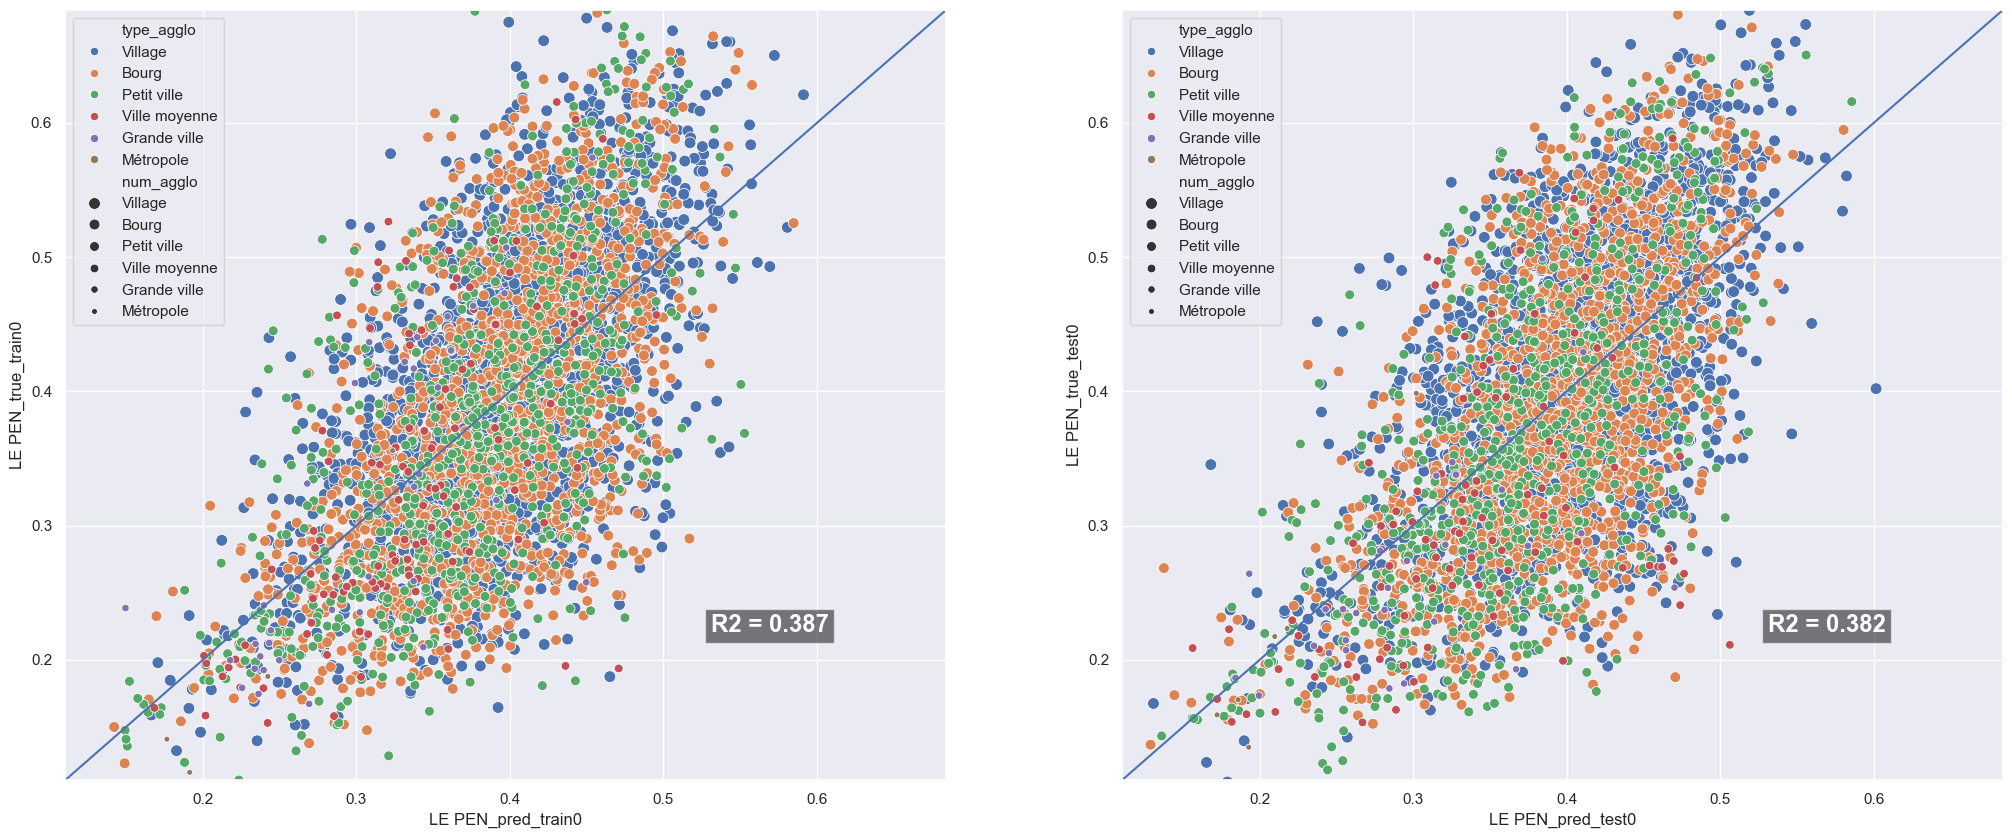

In [88]:
regression_plot(y_train, y_test, pred_list, "LE PEN", town_train_index, town_test_index, turn=2)

In [89]:
features_importancy = pd.DataFrame(list(log_reg.parameters())[0].detach().numpy()[0], columns=["importancy"])

features_importancy["Features"] = sparse_features

features_importancy['abs_importancy'] = features_importancy['importancy'].apply(abs)
features_importancy = features_importancy.sort_values('abs_importancy', ascending=False)
features_importancy

,importancy,Features,abs_importancy
2,-0.263442,ratio_etude_sup,0.263442
3,0.111929,mean_familiy_size,0.111929
1,-0.086803,Indice_vieillissement,0.086803
8,-0.076190,part_agri_y,0.076190
4,0.071555,ratio_no_diploma,0.071555
5,-0.060973,hlm,0.060973
6,0.027722,res_second,0.027722
7,0.012183,ta_homme,0.012183
0,-0.002929,density_pop,0.002929
9,0.001248,part_cadre,0.001248


In [90]:
df = pred_list[0][1]
df["Type_agglo"] = town_train_index["type_agglo"].values
df["True LE PEN"] = y_test.ravel()

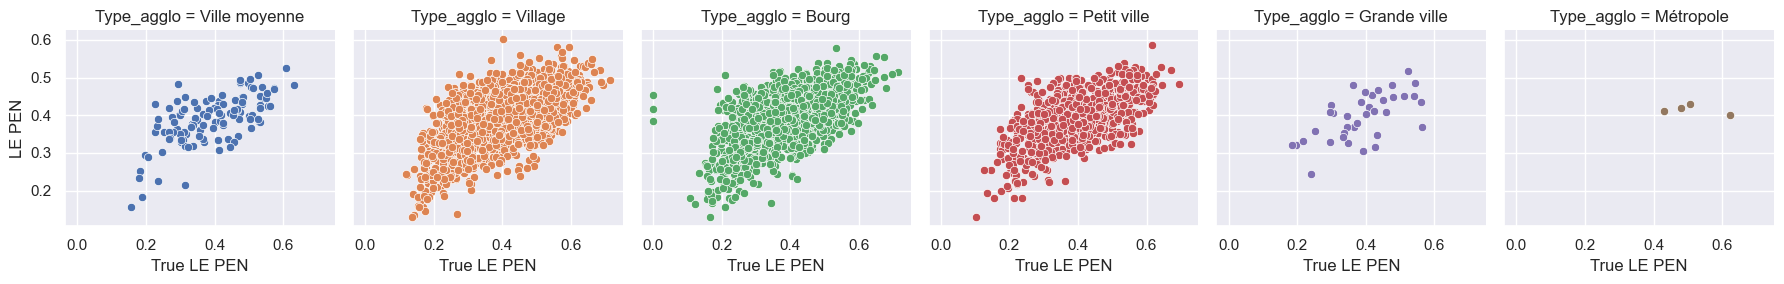

In [91]:
g = sns.FacetGrid(df, col="Type_agglo", hue ="Type_agglo")
g.map(sns.scatterplot, "True LE PEN", "LE PEN")

# NEURAL NETWORKS ON THE DISTRIBUTION RESULTS
Can we improve result by adding one layer ?

In [92]:
models = [Log_reg_one_neuron(nb_features), NN_2Layers_1Neuron(nb_features, 200)]
optims = [torch.optim.Adam(models[0].parameters()), torch.optim.Adam(models[1].parameters())]
loss = [cross_entropy_loss, cross_entropy_loss]

In [93]:
train_neurals_networks(n_epochs=50, train_loader=train_loader, \
                       list_of_loss_function=loss, \
                       list_of_models=models,\
                       list_of_optim=optims,\
                       print_epochs=10)

epoch n° 0
  model n° 0 - loss : 0.2937184880886759
  model n° 1 - loss : 0.05087308418597021
----
epoch n° 10
  model n° 0 - loss : 0.12355653344402237
  model n° 1 - loss : -0.0002916257076394109
----
epoch n° 20
  model n° 0 - loss : 0.05890081160598331
  model n° 1 - loss : -0.0003687244142860263
----
epoch n° 30
  model n° 0 - loss : 0.030650632943780648
  model n° 1 - loss : -0.000383495721579825
----
epoch n° 40
  model n° 0 - loss : 0.016771383361802214
  model n° 1 - loss : -0.00038803955133531303
----


In [94]:
pred_list = pred_model(x_train, x_test, models, turn=2)

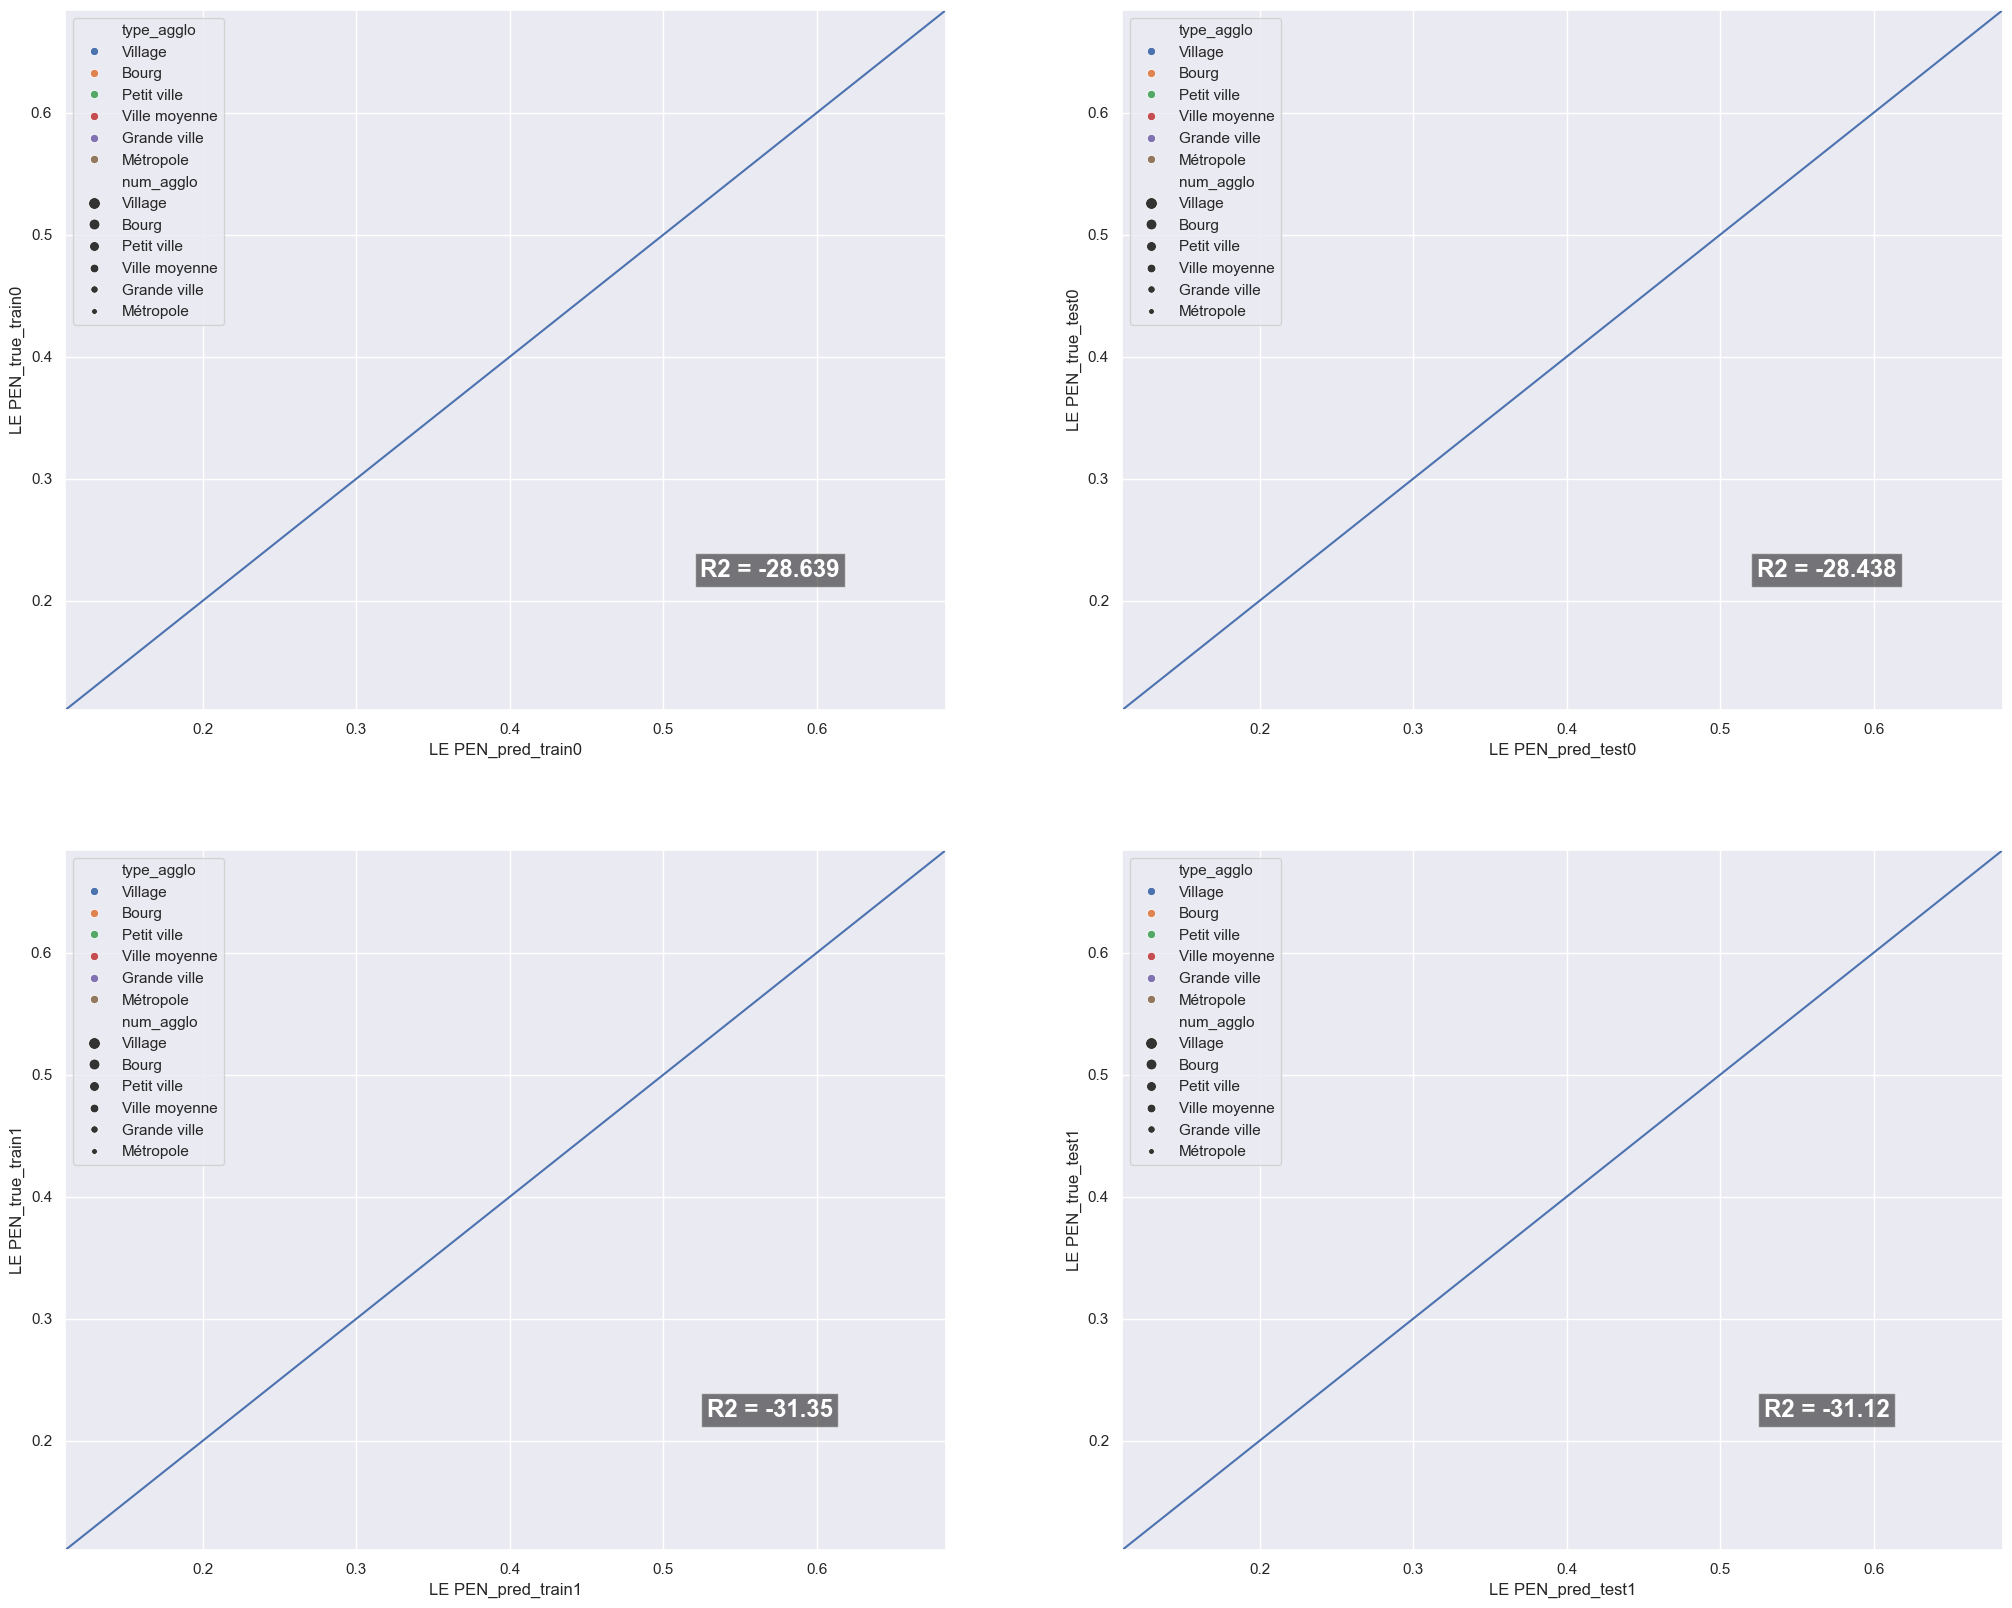

In [95]:
regression_plot(y_train, y_test, pred_list, "LE PEN", town_train_index, town_test_index, turn=2)

# SIMPLE LOGISTIC REGRESSION CLASSIFIER WITH SCIKIT
Here we just take into account the winner to train a simple reg_log classifier.

In [96]:
y_train_winner = np.where(y_train > 0.5, 1, 0)
y_test_winner = np.where(y_test > 0.5, 1, 0)

### SIMPLE LOGISTIC REGRESSION CLASSIFIER
Here we just take into account the winner to train a simple reg_log classifier.

In [97]:
clf_lr = LogisticRegression(solver='liblinear')

param_grid_lr = {"C" : [0.01,0.05,0.1,1.0]}
gridsearch_lr = GridSearchCV(clf_lr,param_grid=param_grid_lr, 
                             cv=10, 
                             scoring='accuracy', 
                             return_train_score=True,
                             refit=True)


gridsearch_lr.fit(x_train, y_train_winner.ravel())
pd.DataFrame(gridsearch_lr.cv_results_).T

,0,1,2,3
mean_fit_time,0.006797,0.00731,0.006953,0.007415
std_fit_time,0.000818,0.000575,0.000216,0.000252
mean_score_time,0.001418,0.001077,0.001049,0.001079
std_score_time,0.000428,0.000094,0.000058,0.000029
param_C,0.01,0.05,0.1,1.0
params,{'C': 0.01},{'C': 0.05},{'C': 0.1},{'C': 1.0}
split0_test_score,0.838496,0.838496,0.838496,0.838496
split1_test_score,0.829646,0.838496,0.834071,0.838496
split2_test_score,0.840708,0.836283,0.834071,0.838496
split3_test_score,0.831858,0.856195,0.860619,0.860619


In [98]:
clf_lr = LogisticRegression(solver='liblinear', C=0.1)
clf_lr.fit(x_train, y_train_winner.ravel())

y_pred = clf_lr.predict(x_test)

print('Confusion matrix : \n ',confusion_matrix(y_test_winner,y_pred))
print('Accuracy : ', accurracy(y_test_winner,y_pred))

Confusion matrix : 
  [[3621   94]
 [ 641  163]]
Accuracy :  0.8373533967691967


### SVM

In [99]:
clf_svc = SVC(gamma='auto')

param_grid_svc = {"C" : [0.01,0.05,0.1,1.0]}
gridsearch_svc = GridSearchCV(clf_svc,param_grid=param_grid_svc, 
                             cv=10, 
                             scoring='accuracy', 
                             return_train_score=True,
                             refit=True)


gridsearch_svc.fit(x_train, y_train_winner.ravel())
pd.DataFrame(gridsearch_svc.cv_results_).T

,0,1,2,3
mean_fit_time,0.280023,0.268303,0.27245,0.299204
std_fit_time,0.015267,0.010546,0.008183,0.015946
mean_score_time,0.069578,0.066814,0.066964,0.064467
std_score_time,0.004133,0.007586,0.003868,0.003566
param_C,0.01,0.05,0.1,1.0
params,{'C': 0.01},{'C': 0.05},{'C': 0.1},{'C': 1.0}
split0_test_score,0.827434,0.827434,0.827434,0.847345
split1_test_score,0.827434,0.827434,0.827434,0.845133
split2_test_score,0.827434,0.827434,0.827434,0.836283
split3_test_score,0.825221,0.825221,0.825221,0.84292


In [100]:
clf = SVC(C=1)
clf.fit(x_train, y_train_winner.ravel())

y_pred = clf.predict(x_test)

print('Confusion matrix : \n ',confusion_matrix(y_test_winner,y_pred))
print('Accuracy : ', accurracy(y_test_winner,y_pred))

Confusion matrix : 
  [[3681   34]
 [ 682  122]]
Accuracy :  0.8415578667846869


### Gradient Boosting Classifier

In [101]:
clf = GradientBoostingClassifier(random_state=0)

param_grid = {"n_estimators" : [100,500],
                "max_depth" : [2,3,4]}

gridsearch = GridSearchCV(clf,param_grid=param_grid, 
                             cv=10, 
                             scoring='accuracy', 
                             return_train_score=True,
                             refit=True)


gridsearch.fit(x_train, y_train_winner.ravel())
pd.DataFrame(gridsearch.cv_results_).T

,0,1,2,3,4,5
mean_fit_time,0.610659,3.061027,1.021293,5.004814,1.237818,5.728374
std_fit_time,0.013762,0.118896,0.06783,0.099337,0.083033,0.082004
mean_score_time,0.001555,0.003297,0.00201,0.004457,0.002097,0.004699
std_score_time,0.000083,0.000477,0.000127,0.000217,0.000409,0.000138
param_max_depth,2,2,3,3,4,4
param_n_estimators,100,500,100,500,100,500
params,"{'max_depth': 2, 'n_estimators': 100}","{'max_depth': 2, 'n_estimators': 500}","{'max_depth': 3, 'n_estimators': 100}","{'max_depth': 3, 'n_estimators': 500}","{'max_depth': 4, 'n_estimators': 100}","{'max_depth': 4, 'n_estimators': 500}"
split0_test_score,0.84292,0.85177,0.85177,0.840708,0.845133,0.834071
split1_test_score,0.858407,0.865044,0.865044,0.871681,0.862832,0.862832
split2_test_score,0.834071,0.849558,0.84292,0.856195,0.840708,0.853982


In [102]:
gridsearch = GradientBoostingClassifier(random_state=0, max_depth=2, n_estimators=200)

gridsearch.fit(x_train, y_train_winner.ravel())
y_pred = gridsearch.predict(x_test) 
print('Confusion matrix : \n ',confusion_matrix(y_test_winner,y_pred))
print('Accuracy : ', accurracy(y_test_winner,y_pred))

Confusion matrix : 
  [[3614  101]
 [ 573  231]]
Accuracy :  0.8508519583978756


### RANDOM FOREST REGRESSION
Objectif : improve R2 score 

In [104]:
regr = RandomForestRegressor(max_depth=10, random_state=0,n_estimators=2000)

In [105]:
regr.fit(x_train, y_train.ravel())

RandomForestRegressor(max_depth=10, n_estimators=2000, random_state=0)

In [106]:
y_pred_test = regr.predict(x_test)

In [107]:
y_pred_train = regr.predict(x_train)

In [108]:
regr.score(x_test, y_test)

0.45337207937190904

In [109]:
regr.score(x_train, y_train)

0.7165059838473329

In [110]:
pred_list = [(pd.DataFrame(y_pred_train, columns=["LE PEN"]), pd.DataFrame(y_pred_test, columns=["LE PEN"]))]

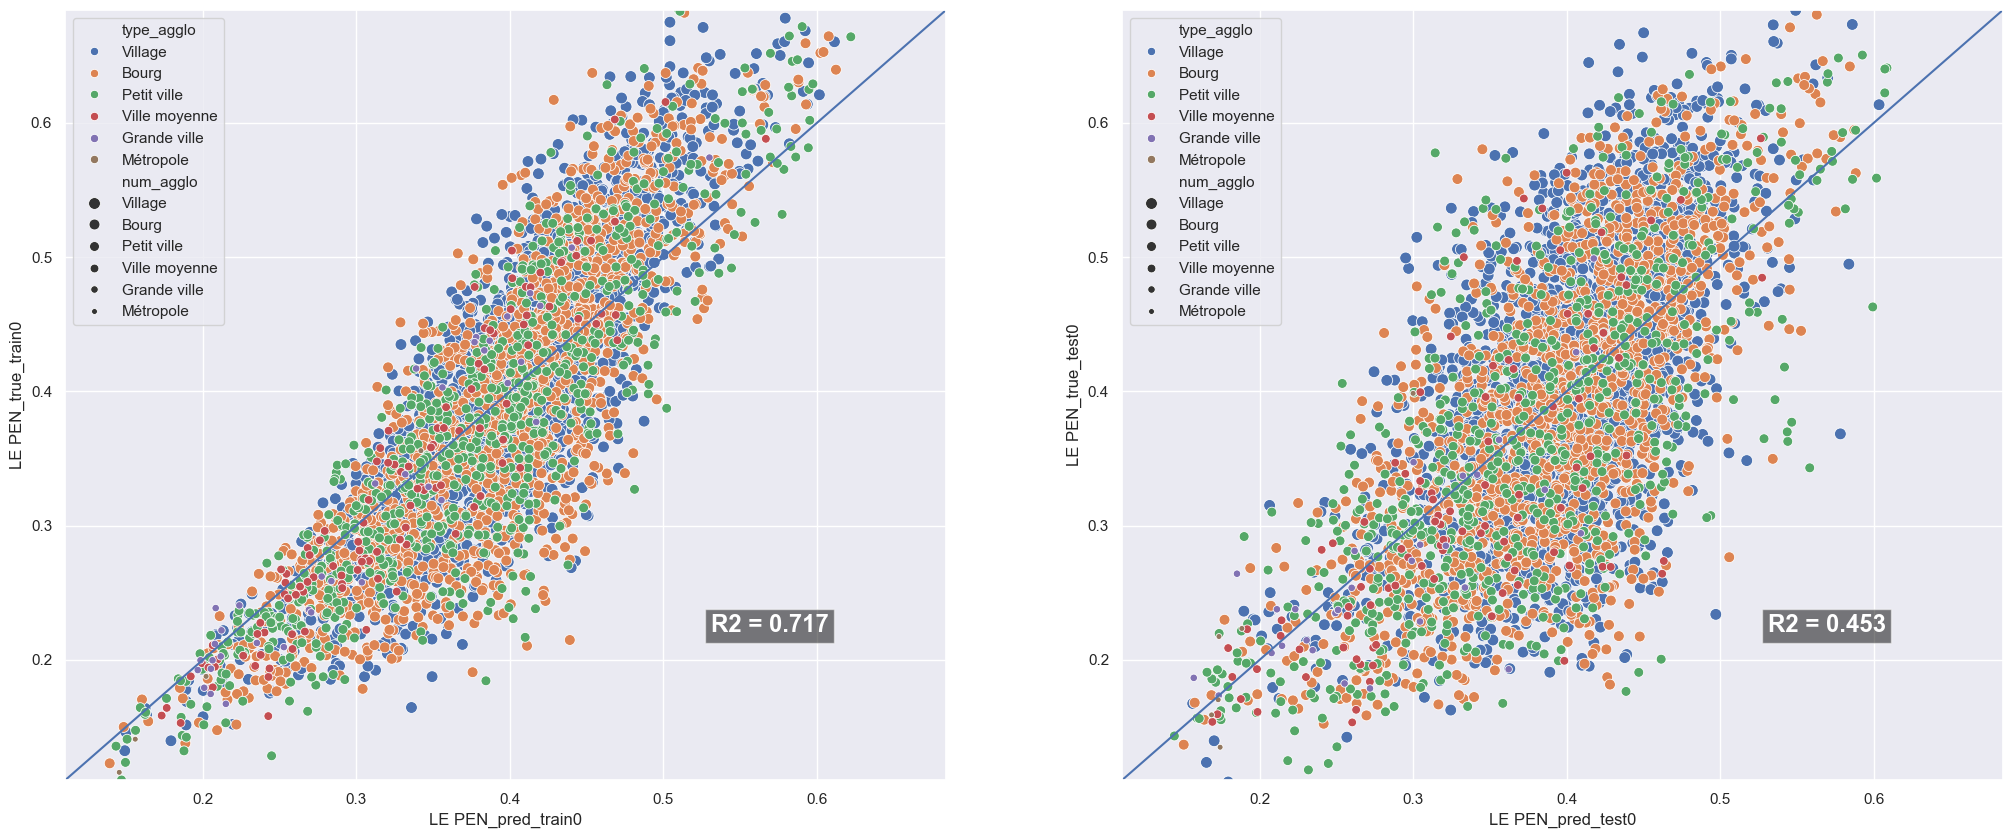

In [111]:
regression_plot(y_train, y_test, pred_list, "LE PEN", town_train_index, town_test_index, turn=2)